In [1]:
from data_utils import load_image_mask_pairs, train_val_split
from datasets import SegmentationDataset, SegPatchDataset
from transforms import get_train_transform, get_val_transform
from MSCE_UNet import create_model
from engine import train_model
from plotting import plot_history

from torch.utils.data import DataLoader
from torch import nn
import torch

1. 读数据 & 划分

In [2]:
from pathlib import Path

root = Path("data")
print("img_dir 存在吗？", (root / "images").exists())
print("mask_dir 存在吗？", (root / "masks").exists())
print("images 里有多少文件？", len(list((root / "images").glob("*"))))
print("masks 里有多少文件？", len(list((root / "masks").glob("*"))))

pairs = load_image_mask_pairs("data")
train_pairs, val_pairs = train_val_split(pairs, val_ratio=0.2)

train_full = SegmentationDataset(train_pairs, num_image_channels=3)
val_full = SegmentationDataset(val_pairs, num_image_channels=3)

img_dir 存在吗？ True
mask_dir 存在吗？ True
images 里有多少文件？ 21
masks 里有多少文件？ 21


2. 增强 & patch dataset

In [3]:
mean = [0.5]
std = [0.5]

train_transform = get_train_transform(
    mean,
    std,
    flip_prob=0.5,
    rotate_prob=0.5,
    elastic_prob=0.3,     # 弹性形变触发概率
    elastic_alpha=10.0,   # 形变强度
    elastic_sigma=4.0,    # 平滑程度
)
val_transform = get_val_transform(mean, std)

train_patches = SegPatchDataset(train_full, patch_size=128, transform=train_transform)
val_patches = SegPatchDataset(val_full, patch_size=128, transform=val_transform)

train_loader = DataLoader(train_patches, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_patches, batch_size=16, shuffle=False, num_workers=4)


3. 模型 / 损失 / 优化器

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = create_model(in_channels=3, num_classes=1, device=device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

4. 训练

In [5]:
history = train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    loss_fn,
    num_epochs=500,
    device=device,
)

Epoch [1/500] Train Loss: 0.2351, Val Loss: 0.2041, Val Dice: 0.0210, Val IoU: 0.0106
Saved best model at epoch 1 (Dice=0.0210)
Epoch [2/500] Train Loss: 0.1553, Val Loss: 0.1429, Val Dice: 0.4244, Val IoU: 0.2693
Saved best model at epoch 2 (Dice=0.4244)
Epoch [3/500] Train Loss: 0.1343, Val Loss: 0.1254, Val Dice: 0.5518, Val IoU: 0.3810
Saved best model at epoch 3 (Dice=0.5518)
Epoch [4/500] Train Loss: 0.1216, Val Loss: 0.1080, Val Dice: 0.6659, Val IoU: 0.4992
Saved best model at epoch 4 (Dice=0.6659)
Epoch [5/500] Train Loss: 0.1128, Val Loss: 0.1000, Val Dice: 0.6992, Val IoU: 0.5375
Saved best model at epoch 5 (Dice=0.6992)
Epoch [6/500] Train Loss: 0.1079, Val Loss: 0.1049, Val Dice: 0.6672, Val IoU: 0.5006
Epoch [7/500] Train Loss: 0.1067, Val Loss: 0.1021, Val Dice: 0.7104, Val IoU: 0.5509
Saved best model at epoch 7 (Dice=0.7104)
Epoch [8/500] Train Loss: 0.1042, Val Loss: 0.0977, Val Dice: 0.7109, Val IoU: 0.5515
Saved best model at epoch 8 (Dice=0.7109)
Epoch [9/500] Trai

5. 画曲线

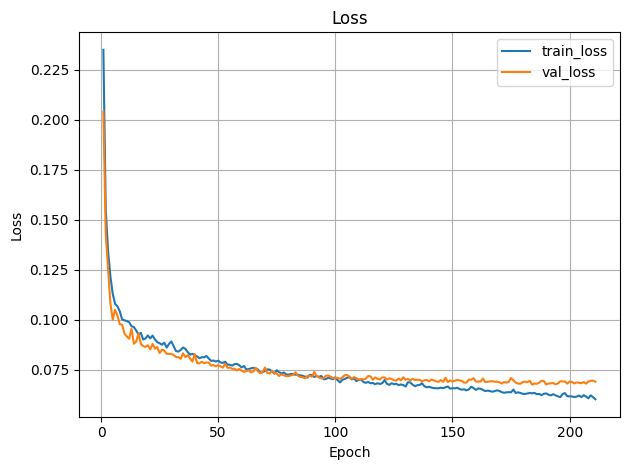

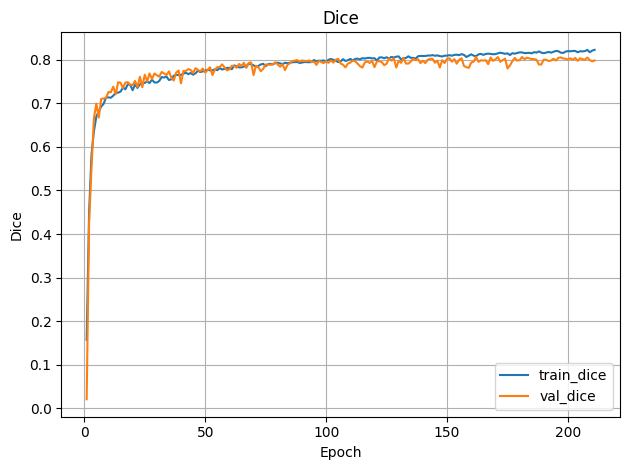

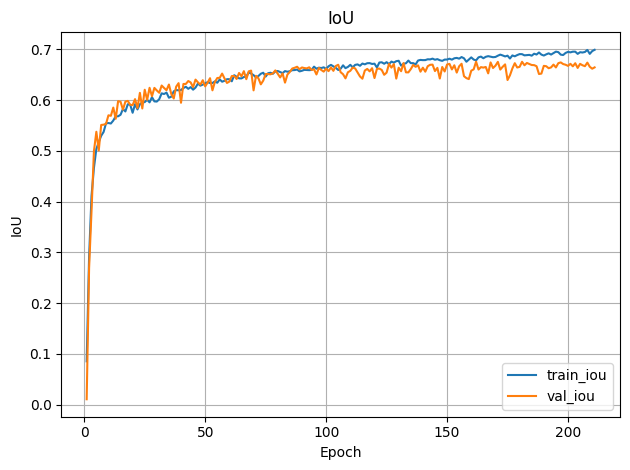

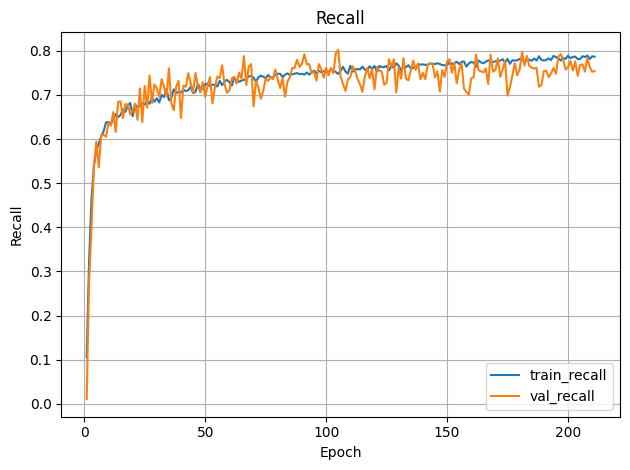

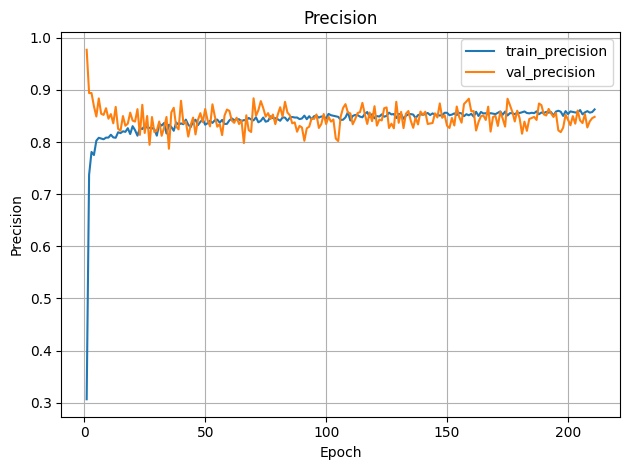

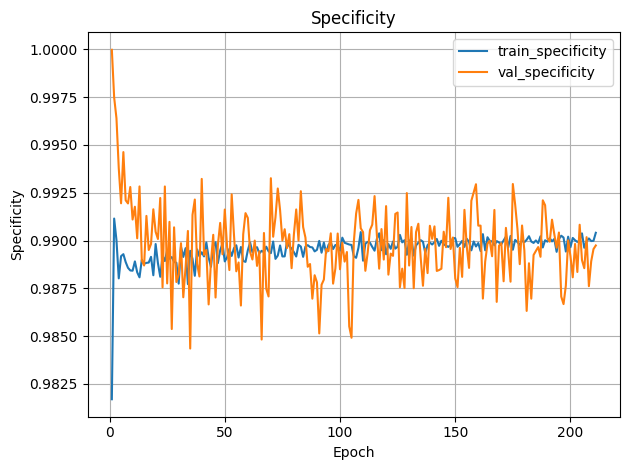

曲线图已保存到: /home/b/.pyioutilx/workspace/DLZX/UNET/training_plots


In [6]:
plot_history(history, save_dir="./training_plots")